# Modelling and Evaluating for Mildew Detection in Cherry Leaves

## Objectives
* Develop a binary classification model to distinguish between healthy and powdery mildew-infected cherry leaves.
* Evaluate the model's performance and optimize it to meet or exceed the project accuracy goal.

## Inputs
* Preprocessed and possibly augmented image data ready for model training.

## Outputs
* Trained machine learning model.
* Evaluation reports detailing the model's performance on test data.

## Additional Comments
* Focus on achieving the balance between model complexity and performance to avoid overfitting.

---

# Import packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

## Set working directory

In [2]:
current_dir = os.getcwd()
print("Original working directory:", current_dir)

Original working directory: /Users/jordanfletorides/Desktop/github repos/ml-mildew-detector/jupyter_notebooks


### Change the current working directory to the project root

In [3]:
relative_path_to_root = '..'
os.chdir(os.path.abspath(os.path.join(current_dir, relative_path_to_root)))

# Verify the change
print("New current working directory:", os.getcwd())

New current working directory: /Users/jordanfletorides/Desktop/github repos/ml-mildew-detector


In [4]:

work_dir = os.getcwd()
work_dir

'/Users/jordanfletorides/Desktop/github repos/ml-mildew-detector'

## Define Input and Output Directories

In [5]:
base_path = "inputs/cherry_leaves_dataset/cherry-leaves"
train_path = os.path.join(base_path, 'train')
validation_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

### Define where to save the outputs

In [6]:
output_dir = 'outputs/model_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Load Image Shape Embeddings

In [7]:
image_shape = joblib.load('outputs/data_visualization/v1/average_image_shape.pkl')

---

# Image Data Augmentation

### ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

* ### Augment training image dataset

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    batch_size=32,
    class_mode='binary'
)

Found 2944 images belonging to 2 classes.


* ### Augment validation image dataset

In [10]:
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=image_shape[:2],
    class_mode='binary'
)

Found 420 images belonging to 2 classes.


* ### Augment test image dataset

In [11]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    class_mode='binary',
    shuffle=False
)

Found 630 images belonging to 2 classes.


---

## Plot augmented images

In [12]:
def plot_augmented_images(datagen, directory_path, image_shape, batch_size=10, rows=2, cols=5):
    """
    Plot augmented images from a specified directory.
    """
    generator = datagen.flow_from_directory(
        directory=directory_path,
        target_size=image_shape[:2],
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    # Get a batch of images
    images, labels = next(generator)
    
    # Plot the images
    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axes.flat):
        if i < batch_size:
            ax.imshow(images[i])
            ax.axis('off')
            ax.set_title(f"Label: {'Healthy' if labels[i] < 0.5 else 'Powdery Mildew'}")
    plt.tight_layout()
    plt.show()


* ### Plot augmented training images

Found 2944 images belonging to 2 classes.


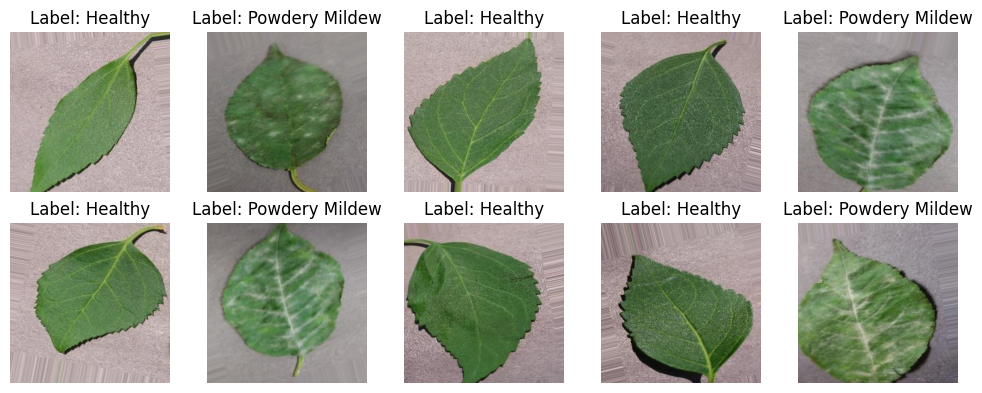

In [13]:
plot_augmented_images(
    datagen=train_datagen,
    directory_path=train_path,
    image_shape=image_shape,
    batch_size=10
)

* ### Plot augmented validation images

Found 420 images belonging to 2 classes.


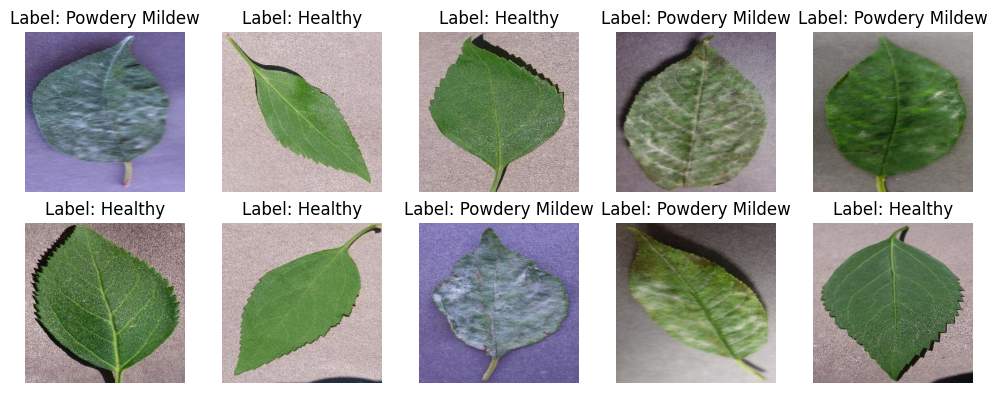

In [14]:
plot_augmented_images(
    datagen=validation_datagen,
    directory_path=validation_path,
    image_shape=image_shape,
    batch_size=10
)

* ### Plot augmented test images

Found 630 images belonging to 2 classes.


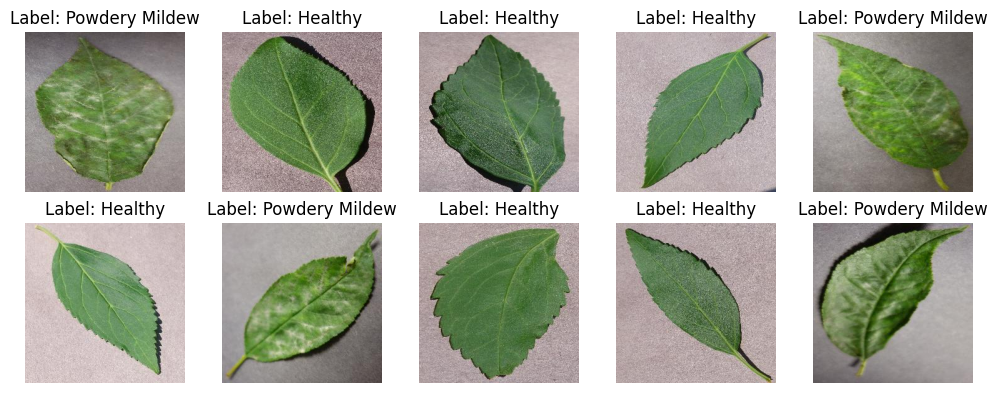

In [15]:
plot_augmented_images(
    datagen=test_datagen,
    directory_path=test_path,
    image_shape=image_shape,
    batch_size=10
)

---

# Model creation

## ML model

In [16]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=image_shape),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/Users/jordanfletorides/Desktop/github repos/ml-mildew-detector/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


* ### Model Summary 

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     3,936,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,946,465 (15.05 MB)

 Trainable params: 3,946,465 (15.05 MB)

 Non-trainable params: 0 (0.00 B)

* ### Early Stopping 

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit Model For Training

In [19]:

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15


/Users/jordanfletorides/Desktop/github repos/ml-mildew-detector/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 421ms/step - accuracy: 0.6034 - loss: 0.8492 - val_accuracy: 0.9833 - val_loss: 0.0667
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.9454 - loss: 0.1619 - val_accuracy: 0.9238 - val_loss: 0.1903
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 397ms/step - accuracy: 0.9450 - loss: 0.1761 - val_accuracy: 0.9952 - val_loss: 0.0274
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 388ms/step - accuracy: 0.9490 - loss: 0.1885 - val_accuracy: 0.9952 - val_loss: 0.0244
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.9540 - loss: 0.1970 - val_accuracy: 0.9881 - val_loss: 0.0943
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.9700 - loss: 0.1627 - val_accuracy: 0.9786 - val_loss: 0.0555
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 387ms/step - accuracy: 0.9876 - loss: 0.1140 - val_accuracy: 0.9905 - val_loss: 0.0241
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 385ms/step - accuracy: 0.9918 - loss: 0.0873 - val_accuracy: 0.938

## Save Model

In [20]:
model_path = os.path.join(output_dir, 'mildew_detector_model.h5')
model.save(model_path)

---

# Model Performace

## Model Performance Visualization

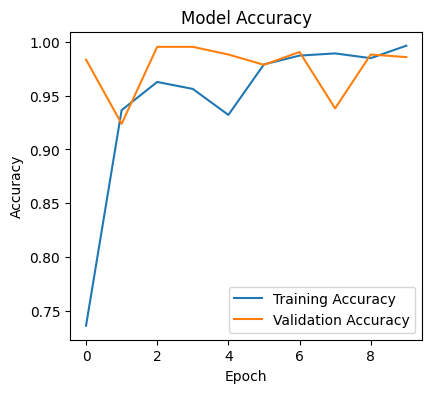

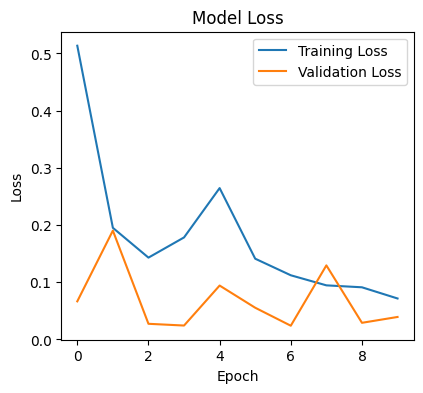

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(output_dir, 'training_accuracy.png'))  # Save plot
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(output_dir, 'training_loss.png'))  # Save plot
plt.show()

Evaluate model on test set

In [26]:
results = model.evaluate(test_generator)
results_dict = {'Test Loss': results[0], 'Test Accuracy': results[1]}  # Creating a dictionary with labels

print(f"Test Loss: {results_dict['Test Loss']}, Test Accuracy: {results_dict['Test Accuracy']}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9954 - loss: 0.0199
Test Loss: 0.049759749323129654, Test Accuracy: 0.9888888597488403


## Save evaluation data

In [23]:
results_path = os.path.join(output_dir, 'test_results.pkl')
joblib.dump(results_dict, results_path)

['outputs/model_outputs/test_results.pkl']

---

## Predict on new data

In [24]:
from tensorflow.keras.preprocessing import image
import random

def predict_random_image_from_final_test():
    # Define the path to the final_test directory
    final_test_path = 'inputs/cherry_leaves_dataset/cherry-leaves/final_test'
    
    # Get a list of all subdirectories (if any)
    subdirectories = [d for d in os.listdir(final_test_path) if os.path.isdir(os.path.join(final_test_path, d))]

    # Choose a random subdirectory if there are any, else use the final_test_path as is
    if subdirectories:
        chosen_dir = random.choice(subdirectories)
        final_test_path = os.path.join(final_test_path, chosen_dir)
    
    # List all files in the chosen directory
    all_files = [f for f in os.listdir(final_test_path) if os.path.isfile(os.path.join(final_test_path, f))]
    
    # Select a random image file
    random_image_name = random.choice(all_files)
    image_path = os.path.join(final_test_path, random_image_name)

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=image_shape[:2])
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    prediction = model.predict(img_array)
    predicted_class = "Powdery Mildew" if prediction[0] > 0.5 else "Healthy"

    # Display the image and the prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


Run the function to predict and display a random image from final_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


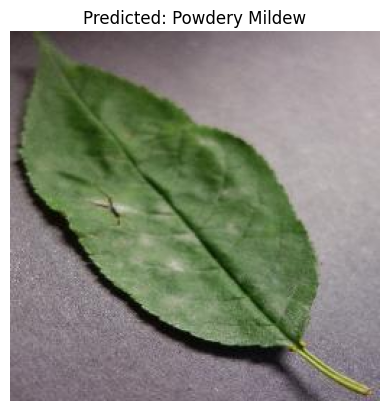

In [25]:
predict_random_image_from_final_test()

---